In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the pickle file
file_path = "/Users/IrisW/Documents/0Macaskill/AST_data/AM_GH3_4_merged_data.pkl"  # Update this path as needed
with open(file_path, "rb") as file:
    data = pickle.load(file)
# Ensure the data is a DataFrame
if not isinstance(data, pd.DataFrame):
    raise ValueError("The loaded data is not a Pandas DataFrame.")

In [ ]:
data['GH_ISO'] = 'GH'

In [ ]:
# Load the pickle file
file_path = "/Users/IrisW/Documents/0Macaskill/AST_data/gabi_ast.pkl"  # Update this path as needed
with open(file_path, "rb") as file:
    gabi_data = pickle.load(file)

In [ ]:
gabi_data['Animal'].nunique()


In [ ]:
print(data.columns)
print(gabi_data.columns)

In [ ]:
df_test = data.loc[:,'animal']

In [ ]:
%reset -f

In [ ]:
del data

In [ ]:
pickle_file = "/Users/IrisW/Documents/0Macaskill/AST_data/AM_GH3_4_merged_data.pkl"
data.to_pickle(pickle_file)

In [ ]:
data['initial_dimension'] = data['animal'].map({
    'AM_GH3': 'odor',
    'AM_GH4': 'medium'
})

In [ ]:
# know the total trials of each session per animal
trial_counts = data.groupby(["session", "animal"]).size().reset_index(name="total_trials")

SHAPING

In [ ]:
file_path = "/Users/IrisW/Documents/0Macaskill/AST_data/AM_GH4/AM_GH4_raw/20250308_shaping/shaping20250308_AM_GH4.pkl"  # Update this path as needed
with open(file_path, "rb") as file:
    shape_data = pickle.load(file)

ERROR ANALYSIS

In [ ]:
# error analysis block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Load data (skip this if your DataFrame is already loaded)
# df = pd.read_pickle("your_file_path.pkl")

# Ensure correct column is numeric and clean
data['correct'] = pd.to_numeric(data['correct'], errors='coerce')
df = data.dropna(subset=['correct'])


In [ ]:
gabi_data["Correct?"]

In [ ]:
# change to gabi's dataframe
# Ensure correct column is numeric and clean
gabi_data["Correct?"] = pd.to_numeric(gabi_data["Correct?"], errors='coerce')
df = gabi_data.dropna(subset=["Correct?"])


In [ ]:
### 1. Correct Streak Lengths Before Errors

from collections import defaultdict

streak_data = []

for (animal, session), group in df.groupby(['animal', 'session']):
    group = group.sort_index()
    correct_streak = 0

    for val in group['correct']:
        if val == 1:
            correct_streak += 1
        elif val == 0:
            streak_data.append({
                'animal': animal,
                'session': session,
                'correct_streak_before_error': correct_streak
            })
            correct_streak = 0

streak_df = pd.DataFrame(streak_data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='session', y='correct_streak_before_error', data=streak_df, palette = 'tab20')
plt.xticks(rotation=45)
plt.title("Correct Streak Lengths Before Errors (per Session)")
plt.ylabel("Number of Correct Trials Before Error")
plt.tight_layout()
plt.show()


In [ ]:
### 2. Error Position Distribution

error_positions = []

for (animal, session), group in df.groupby(['animal', 'session']):
    group = group.sort_index()
    for idx, val in enumerate(group['correct']):
        if val == 0:
            error_positions.append({
                'animal': animal,
                'session': session,
                'trial_index': idx
            })

error_positions_df = pd.DataFrame(error_positions)

plt.figure(figsize=(12, 6))
sns.histplot(data=error_positions_df, x='trial_index', hue='session', multiple='stack', bins=53, palette = 'tab20')
plt.title("Error Position Distribution Across Sessions")
plt.xlabel("Trial Index (Position in Session)")
plt.ylabel("Number of Errors")
plt.tight_layout()
plt.show()

In [ ]:
### 3. Hazard Function

MAX_STREAK = 15
hazard_counts = np.zeros(MAX_STREAK + 1)
hazard_total = np.zeros(MAX_STREAK + 1)

for (animal, session), group in df.groupby(['animal', 'session']):
    group = group.sort_index()
    streak = 0
    for val in group['correct']:
        if val == 0:
            capped_streak = min(streak, MAX_STREAK)
            hazard_counts[capped_streak] += 1
            streak = 0
        else:
            capped_streak = min(streak, MAX_STREAK)
            hazard_total[capped_streak] += 1
            streak += 1

hazard_rate = hazard_counts / (hazard_counts + hazard_total)
hazard_x = np.arange(MAX_STREAK + 1)

plt.figure(figsize=(8, 5))
plt.plot(hazard_x, hazard_rate, marker='o')
plt.title("Hazard Function: Probability of Error After N Correct Trials")
plt.xlabel("Number of Consecutive Correct Trials")
plt.ylabel("P(Error | N Correct Trials)")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_76160/4279248583.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for session, group in df_filtered[df_filtered['animal'] == animal_id].groupby('session'):


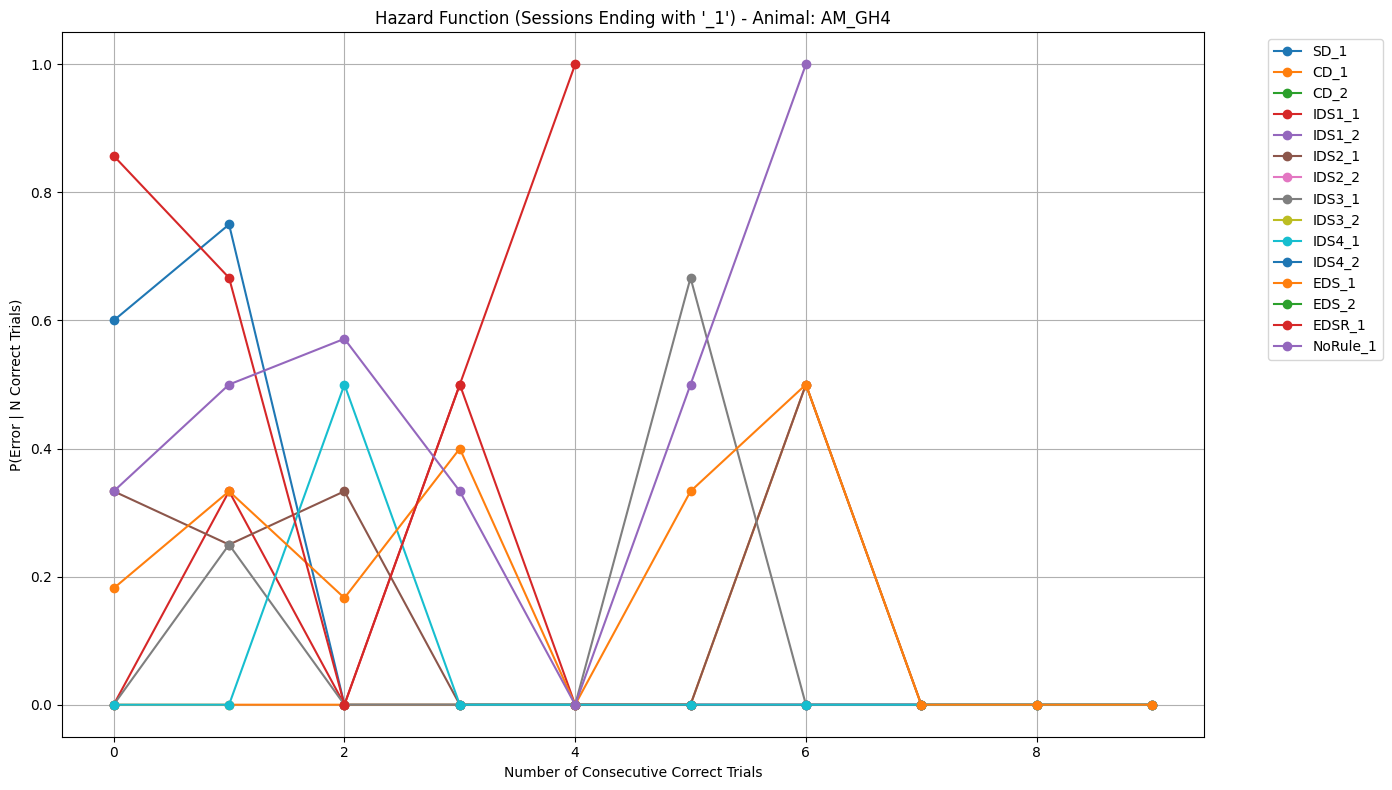

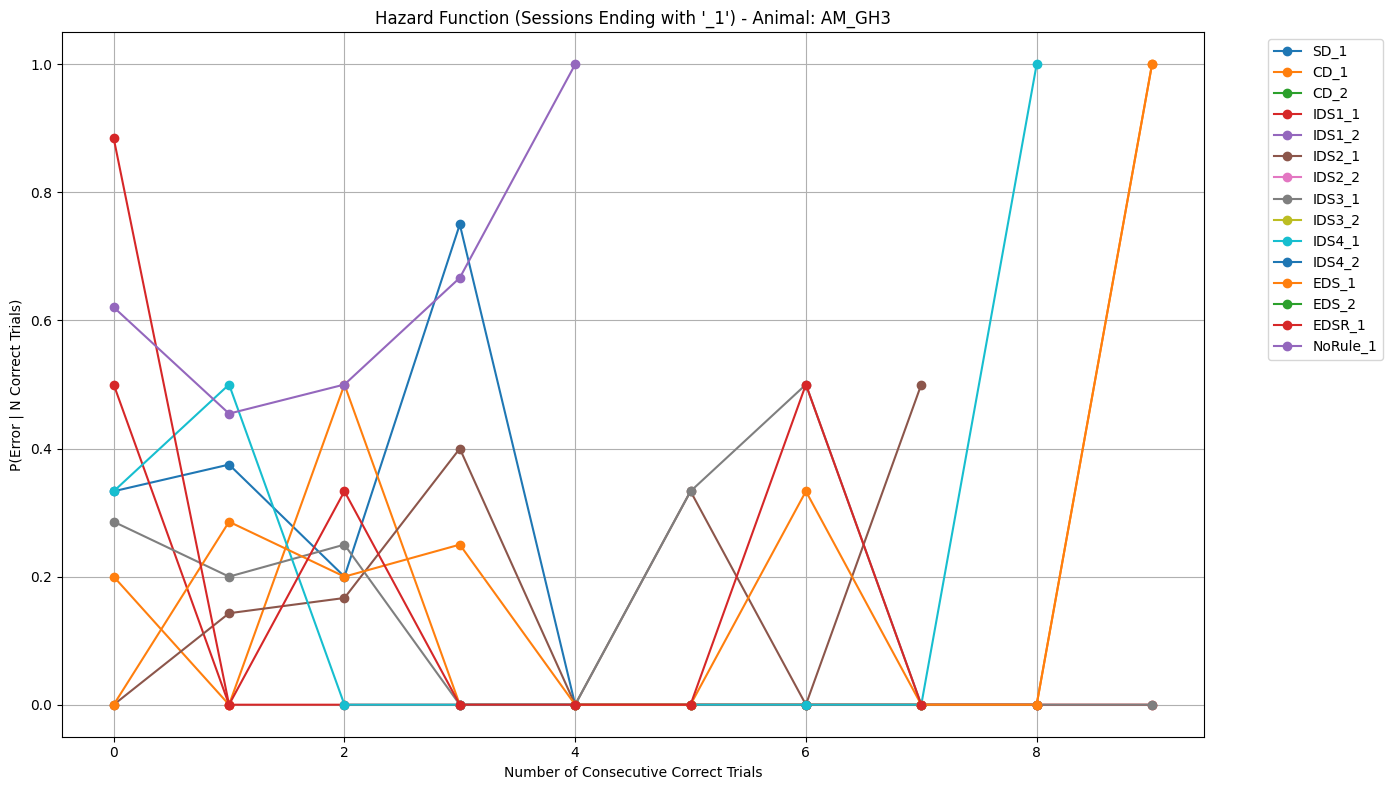

In [61]:
# hazard function to individual mouse with certain session

df_filtered = df[df['session'].str.endswith('_1')].copy()
# Parameters
MAX_STREAK = 15
animals = df_filtered['animal'].unique()

# Compute and plot per animal
for animal_id in animals:
    hazard_per_session = {}

    for session, group in df_filtered[df_filtered['animal'] == animal_id].groupby('session'):
        hazard_counts = np.zeros(MAX_STREAK + 1)
        hazard_total = np.zeros(MAX_STREAK + 1)

        group = group.sort_index()
        streak = 0
        for val in group['correct']:
            if val == 0:
                capped_streak = min(streak, MAX_STREAK)
                hazard_counts[capped_streak] += 1
                streak = 0
            else:
                capped_streak = min(streak, MAX_STREAK)
                hazard_total[capped_streak] += 1
                streak += 1

        with np.errstate(divide='ignore', invalid='ignore'):
            hazard_rate = hazard_counts / (hazard_counts + hazard_total)
        hazard_per_session[session] = hazard_rate

    # Plot for current animal
    plt.figure(figsize=(14, 8))
    for session, rate in hazard_per_session.items():
        plt.plot(np.arange(MAX_STREAK + 1), rate, marker='o', label=session)

    plt.title(f"Hazard Function (Sessions Ending with '_1') - Animal: {animal_id}")
    plt.xlabel("Number of Consecutive Correct Trials")
    plt.ylabel("P(Error | N Correct Trials)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [63]:
df_filtered['session'].unique()

['SD_1', 'CD_1', 'IDS1_1', 'IDS2_1', 'IDS3_1', 'IDS4_1', 'EDS_1', 'EDSR_1', 'NoRule_1']
Categories (15, object): ['SD_1' < 'CD_1' < 'CD_2' < 'IDS1_1' ... 'EDS_1' < 'EDS_2' < 'EDSR_1' < 'NoRule_1']

In [64]:
df_try = df_filtered.loc[:,'session']
df_try['session'].unique()

KeyError: 'session'

In [ ]:
# change to gabi's dataframe
# Ensure correct column is numeric and clean
gabi_data["Correct?"] = pd.to_numeric(gabi_data["Correct?"], errors='coerce')
df = gabi_data.dropna(subset=["Correct?"])

In [ ]:
### 1. Correct Streak Lengths Before Errors

from collections import defaultdict

streak_data = []

for (animal, session), group in df.groupby(['Animal', 'Session']):
    group = group.sort_index()
    correct_streak = 0

    for val in group['Correct?']:
        if val == 1:
            correct_streak += 1
        elif val == 0:
            streak_data.append({
                'Animal': animal,
                'Session': session,
                'correct_streak_before_error': correct_streak
            })
            correct_streak = 0

streak_df = pd.DataFrame(streak_data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Session', y='correct_streak_before_error', data=streak_df, palette = 'tab20')
plt.xticks(rotation=45)
plt.title("Correct Streak Lengths Before Errors (per Session)")
plt.ylabel("Number of Correct Trials Before Error")
plt.tight_layout()
plt.show()

In [ ]:
### 2. Error Position Distribution

error_positions = []

for (animal, session), group in df.groupby(['Animal', 'Session']):
    group = group.sort_index()
    for idx, val in enumerate(group['Correct?']):
        if val == 0:
            error_positions.append({
                'Animal': animal,
                'Session': session,
                'trial_index': idx
            })

error_positions_df = pd.DataFrame(error_positions)

plt.figure(figsize=(12, 6))
sns.histplot(data=error_positions_df, x='trial_index', hue='Session', multiple='stack', bins=53, palette = 'tab20')
plt.title("Error Position Distribution Across Sessions")
plt.xlabel("Trial Index (Position in Session)")
plt.ylabel("Number of Errors")
plt.tight_layout()
plt.show()

In [ ]:
# plot two animals all the session together, line-point graph.
# Count the number of trials per session for each animal
trial_counts = data.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)

plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal")
plt.xticks(rotation=45)
plt.legend(title="Animal")
plt.grid(True)
plt.show()

In [ ]:
### show only "_1" sessions and exclude "NoRule_1" session.
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_1"))].copy()

# Count the number of trials per session for each animal
trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Explicitly filter trial_counts again to ensure only correct sessions are included
trial_counts = trial_counts[trial_counts["session"].isin(data_filtered["session"].unique())]

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 55)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

In [ ]:
### show only "_2" sessions and exclude "NoRule_1" session.
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_2"))].copy()

# Count the number of trials per session for each animal
trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Explicitly filter trial_counts again to ensure only correct sessions are included
trial_counts = trial_counts[trial_counts["session"].isin(data_filtered["session"].unique())]

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 30)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
# Count the number of incorrect (correct == 0) trials per session for each animal
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_1"))].copy()
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")
# Explicitly filter trial_counts again to ensure only correct sessions are included
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]
# Pivot the data for plotting
pivot_data = incorrect_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the bar chart
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total errors per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 50)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter sessions: Include only sessions that explicitly end with '_1' and exclude "NoRule_1"
data_filtered = data[(data["session"].str.endswith("_1")) & (data["session"] != "NoRule_1")].copy()

# Count the number of total trials per session for each animal
total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Count the number of incorrect (correct == 0) trials per session for each animal
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")

# Ensure that both total_counts and incorrect_counts only include filtered sessions
total_counts = total_counts[total_counts["session"].isin(data_filtered["session"].unique())]
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]

# Convert categorical columns to string
for col in ["session", "animal"]:
    if col in total_counts and pd.api.types.is_categorical_dtype(total_counts[col]):
        total_counts[col] = total_counts[col].astype(str)
    if col in incorrect_counts and pd.api.types.is_categorical_dtype(incorrect_counts[col]):
        incorrect_counts[col] = incorrect_counts[col].astype(str)

# Merge the two dataframes
merged_counts = pd.merge(total_counts, incorrect_counts, on=["session", "animal"], how="left").fillna(0)

# Re-filter merged_counts after merging
merged_counts = merged_counts[merged_counts["session"].isin(data_filtered["session"].unique())]

# Define the desired session order
session_order = ["SD_1", "CD_1", "IDS1_1", "IDS2_1", "IDS3_1", "IDS4_1", "EDS_1", "EDSR_1"]
# Sort data by session order
merged_counts["session"] = pd.Categorical(merged_counts["session"], categories=session_order, ordered=True)
merged_counts = merged_counts.sort_values("session")

# Pivot data for plotting
total_pivot = merged_counts.pivot(index="session", columns="animal", values="total_trials")
incorrect_pivot = merged_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Width of bars
x = np.arange(len(total_pivot.index))  # X locations for the groups

# Plot total trials as bars
for i, animal in enumerate(total_pivot.columns):
    ax1.bar(x + i * bar_width, total_pivot[animal], width=bar_width, label=f"Total - {animal}", alpha=0.7)
    ax1.bar(x + i * bar_width, incorrect_pivot[animal], width=bar_width, label=f"Incorrect - {animal}", alpha=0.7, color='red')
    # Find the middle of the total trials bar and plot the point
    middle_x = x + i * bar_width
    top_y = total_pivot[animal]
    ax1.plot(middle_x, top_y, marker="o", linestyle="-", color="black", label="" if i > 0 else "Total Trials Line")

ax1.set_xlabel("Session")
ax1.set_ylabel("Number of Trials")
ax1.set_title("Total and Incorrect Trials per Session for Each Animal")
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(total_pivot.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter sessions: Include only sessions that explicitly end with '_1' and exclude "NoRule_1"
data_filtered = data[(data["session"].str.endswith("_2")) & (data["session"] != "NoRule_1")].copy()

# Count the number of total trials per session for each animal
total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Count the number of incorrect (correct == 0) trials per session for each animal
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")

# Ensure that both total_counts and incorrect_counts only include filtered sessions
total_counts = total_counts[total_counts["session"].isin(data_filtered["session"].unique())]
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]

# Convert categorical columns to string
for col in ["session", "animal"]:
    if col in total_counts and pd.api.types.is_categorical_dtype(total_counts[col]):
        total_counts[col] = total_counts[col].astype(str)
    if col in incorrect_counts and pd.api.types.is_categorical_dtype(incorrect_counts[col]):
        incorrect_counts[col] = incorrect_counts[col].astype(str)

# Merge the two dataframes
merged_counts = pd.merge(total_counts, incorrect_counts, on=["session", "animal"], how="left").fillna(0)

# Re-filter merged_counts after merging
merged_counts = merged_counts[merged_counts["session"].isin(data_filtered["session"].unique())]

# Define the desired session order
session_order = ["CD_2", "IDS1_2", "IDS2_2", "IDS3_2", "IDS4_2", "EDS_2"]
# Sort data by session order
merged_counts["session"] = pd.Categorical(merged_counts["session"], categories=session_order, ordered=True)
merged_counts = merged_counts.sort_values("session")

# Pivot data for plotting
total_pivot = merged_counts.pivot(index="session", columns="animal", values="total_trials")
incorrect_pivot = merged_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Width of bars
x = np.arange(len(total_pivot.index))  # X locations for the groups

# Plot total trials as bars
for i, animal in enumerate(total_pivot.columns):
    ax1.bar(x + i * bar_width, total_pivot[animal], width=bar_width, label=f"Total - {animal}", alpha=0.7)
    ax1.bar(x + i * bar_width, incorrect_pivot[animal], width=bar_width, label=f"Incorrect - {animal}", alpha=0.7, color='red')
    # Find the middle of the total trials bar and plot the point
    middle_x = x + i * bar_width
    top_y = total_pivot[animal]
    ax1.plot(middle_x, top_y, marker="o", linestyle="-", color="black", label="" if i > 0 else "Total Trials Line")

ax1.set_xlabel("Session")
ax1.set_ylabel("Number of Trials")
ax1.set_title("Total and Incorrect Trials per Session for Each Animal")
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(total_pivot.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
